# Tutorial : Dynap-SE2 (UNDER CONSTRUCTION)

In [1]:
# Utils
import time

# Samna
from samna.dynapse2 import *

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Dynap-SE2
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.samna_alias import dynapse2 as ds2
from rockpool.devices.dynapse.utils.se2 import connect, get_model, disconnect, capture_timeseries_from_device, dispatch_timeseries_to_device
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train
from rockpool.devices.dynapse.utils.figure import Figure

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

WARNING    <frozen importlib._bootstrap>:228: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.9
 [py.warnings]



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



No protocol specified


## Utils

In [2]:
def set_parameter(parameters, name, coarse, fine):
    parameter = parameters[name]
    parameter.coarse_value = coarse
    parameter.fine_value = fine

## Connect to device

In [3]:
board = connect("./bitfiles/Dynapse2Stack.bit")
model = get_model(board)

## Get model config

In [4]:
myConfig = model.get_configuration()

## Configure Parameters Manually

In [5]:
# [] TODO : All at once
print("Configuring parameters")
# set neuron parameters
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_GAIN_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_LEAK_N", 0, 50)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_REFR_N", 1, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_DC_P", 0, 1)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOIF_SPKTHR_P", 3, 254)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_PWTAU_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_GAIN_P", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_TAU_P", 0, 10)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_W_N", 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_CASC_P", 5, 254)

# set synapse parameters  -- enabled AM and SC

set_parameter(myConfig.chips[0].cores[0].parameters, 'DEAM_ETAU_P', 2, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DEAM_EGAIN_P', 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DENM_ETAU_P', 1, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DENM_EGAIN_P', 3, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DESC_ITAU_P', 1, 160)
set_parameter(myConfig.chips[0].cores[0].parameters, 'DESC_IGAIN_P', 4, 40)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W0_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W1_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W2_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYAM_W3_P', 5, 80)
set_parameter(myConfig.chips[0].cores[0].parameters, 'SYPD_EXT_N', 3, 200)


Configuring parameters


## Configure Memory

In [6]:
sender_tag = 1024
receiver_tag = 15

In [7]:
print("Configuring cams")

# set CAM -- synapses
cams = [Dynapse2Synapse() for _ in range(64)]
cams[0].tag = sender_tag
cams[0].dendrite = Dendrite.ampa
cams[0].weight = [True, True, True, True]
myConfig.chips[0].cores[0].neurons[0].synapses = cams

Configuring cams


In [8]:
print("Configuring srams")

destinations = [Dynapse2Destination() for _ in range(4)]
destinations[0].tag = receiver_tag
destinations[0].core = [True, False, False, False]
destinations[0].x_hop = -2
myConfig.chips[0].cores[0].neurons[0].destinations = destinations

model.apply_configuration(myConfig)
time.sleep(1)


Configuring srams


## Generate Events

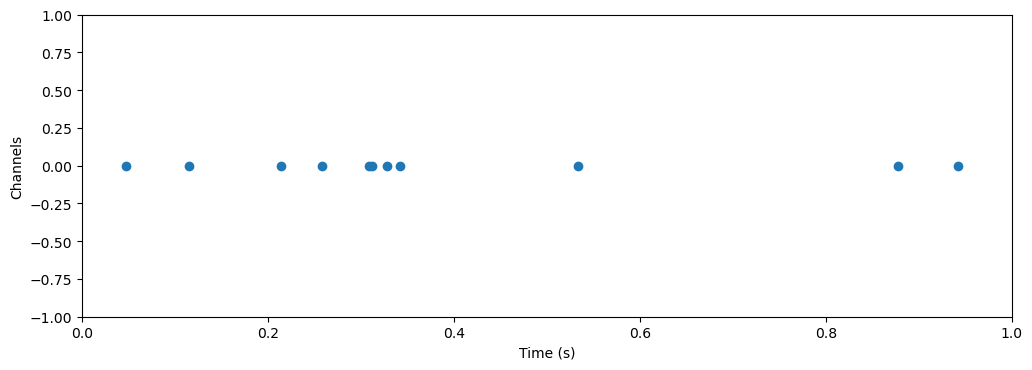

In [9]:
pst = poisson_spike_train(1, 1.0, 10, 1e-6)
ts_poisson = TSEvent.from_raster(pst, 1e-6)
ts_poisson.plot()

In [10]:
channel_map = {0:ds2.Dynapse2Destination(core=[True, False, False, False], x_hop=0, y_hop=0, tag=1024)}

## Send Events

In [11]:
ts_input = dispatch_timeseries_to_device(board, ts_poisson, channel_map, offset=1.0)

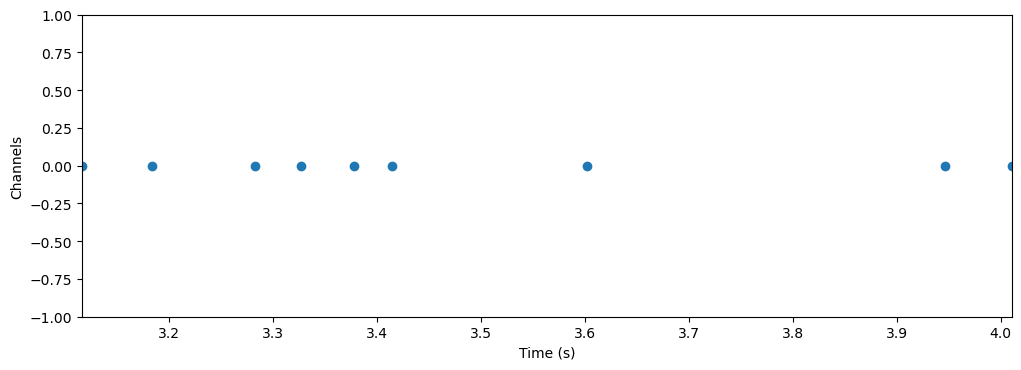

In [12]:
ts_out, cmap_out = capture_timeseries_from_device(board, 6.0)
ts_out.plot()

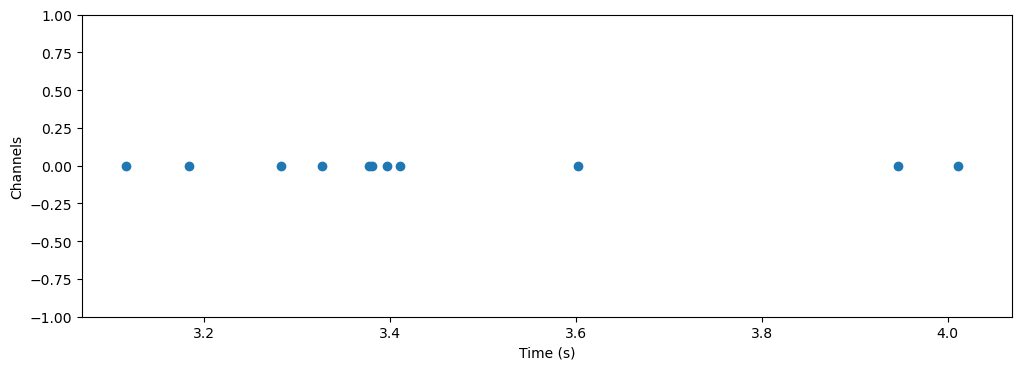

In [13]:
ts_input.plot()

In [14]:
disconnect(board)

In [15]:
simconfig = DynapSimConfig.from_Dynapse2Configuration(myConfig)

In [16]:
n_in = len(simconfig.router.tag_map_in)
n_rec = len(simconfig.router.idx_map)
n_out  = len(simconfig.router.tag_map_out)
n_syn = 4

In [17]:
# --- Input Layer --- #
linear_in = LinearJax(
    shape=(n_in, n_rec*n_syn),
    weight=simconfig.w_in.reshape(n_in,-1),
    has_bias=False,
)
linear_in

LinearJax  with shape (1, 4)

In [18]:
# --- DynapSim Layer --- #
dynapsim = DynapSim.from_DynapSimConfig(
    shape=(n_rec * n_syn, n_rec), has_rec=True, simconfig=simconfig
)
dynapsim

DynapSim  with shape (4, 1)

In [19]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSim '1_DynapSim' with shape (4, 1)
}

In [20]:
model.reset_state()
out, state, record_dict = model(pst, record=True)

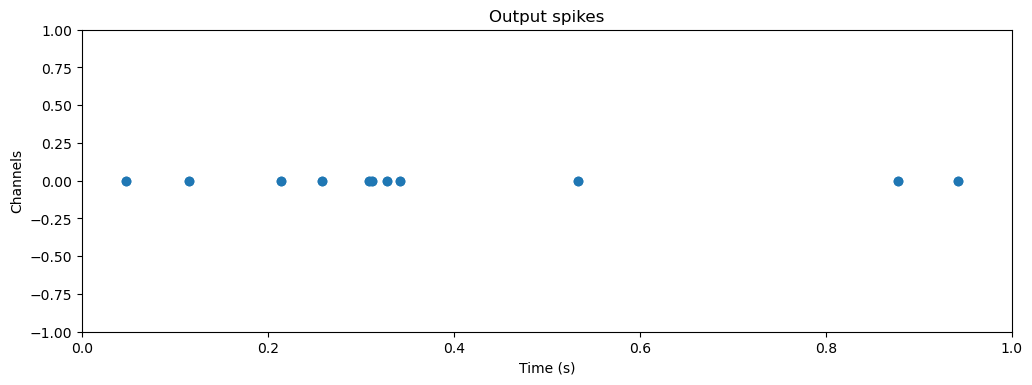

In [21]:
ts_out = TSEvent.from_raster(out, name="Output spikes", periodic=True, dt=1e-6)
ts_out.plot()

### Membrane Current and Membrane Potential

non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 1000000. Channels: 1

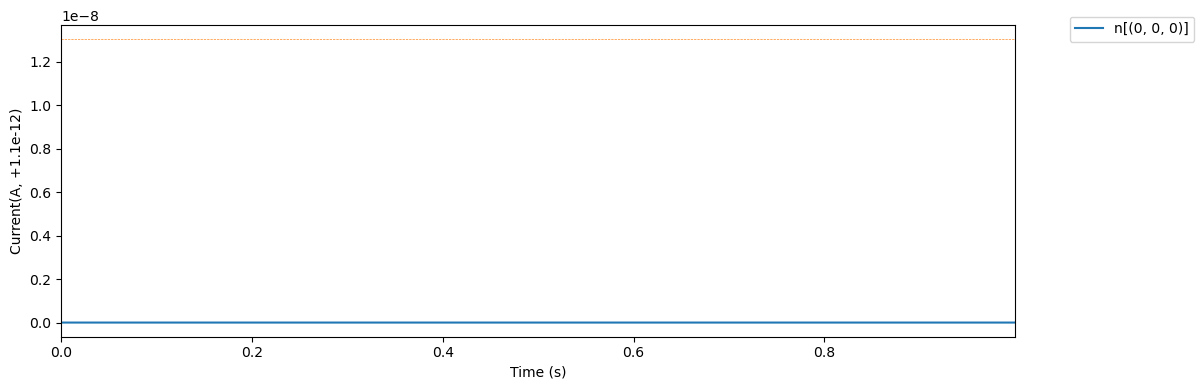

In [22]:
Figure.plot_Ix(record_dict["1_DynapSim"]["imem"], simconfig.Ispkthr, idx_map=simconfig.router.idx_map, dt=1e-6)


non-periodic TSContinuous object `unnamed` from t=0.0 to 1.0. Samples: 1000000. Channels: 1

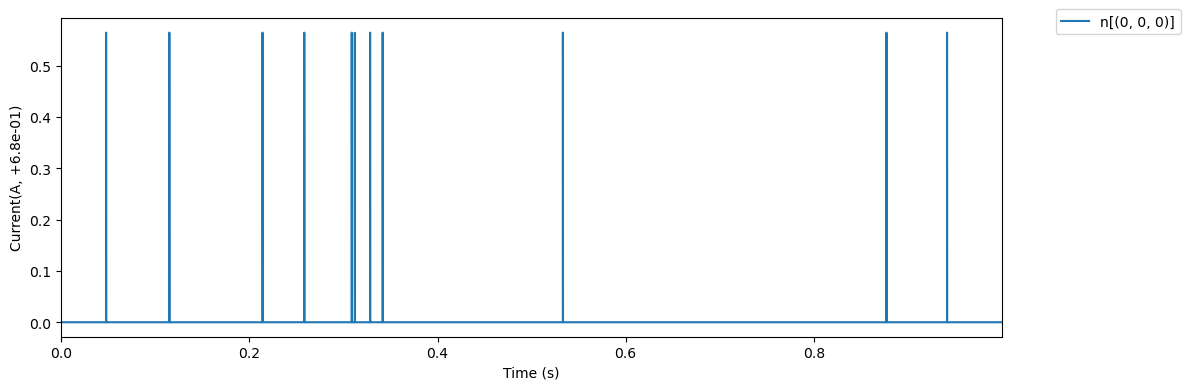

In [23]:
Figure.plot_Ix(record_dict["1_DynapSim"]["vmem"], idx_map=simconfig.router.idx_map, dt=1e-6)


### Synaptic Currents

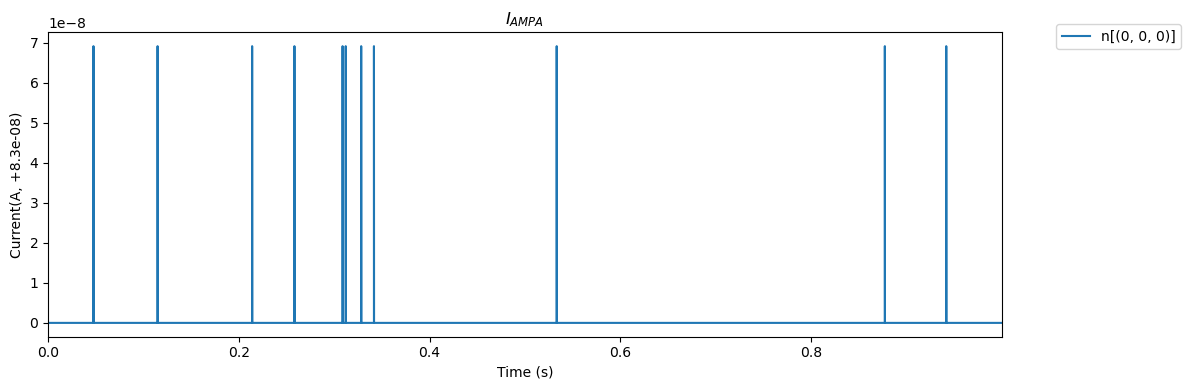

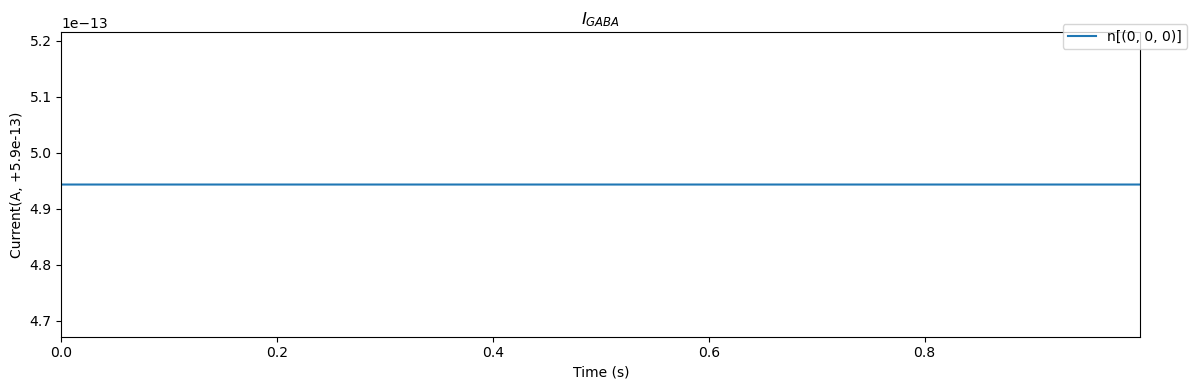

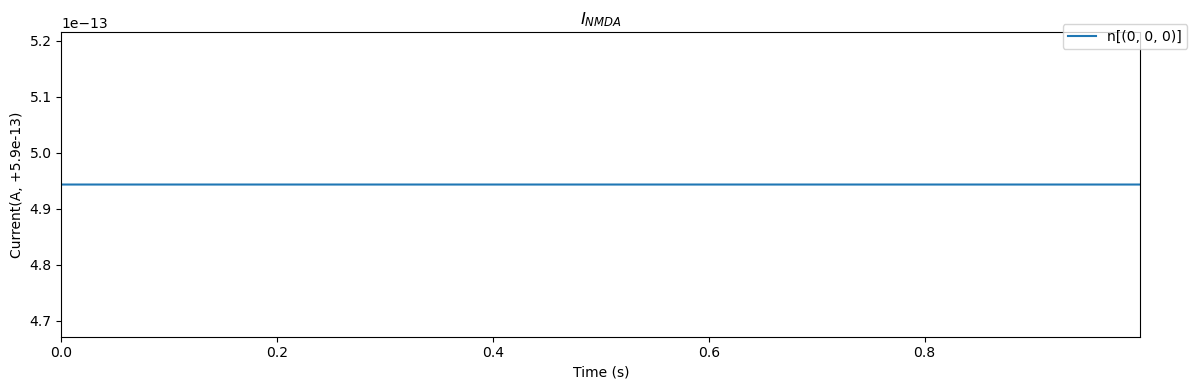

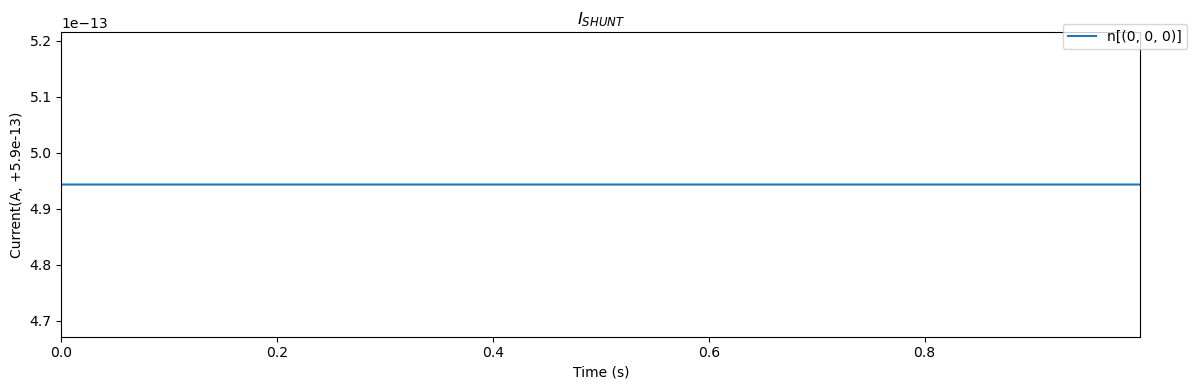

In [24]:
for c in ["AMPA", "GABA", "NMDA", "SHUNT"]:
    plt.figure()
    Figure.plot_Ix(
        record_dict["1_DynapSim"][f"i{c.lower()}"],
        name=f"$I_{{{c}}}$",
        idx_map=simconfig.router.idx_map,
        dt=1e-6,
    )


### Trace the effect of recurrent & input spikes on synaptic currents

(non-periodic TSContinuous object `$I_{AMPA}$ n[(0, 0, 0)]` from t=0.0 to 1.0. Samples: 1000000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 1. Events: 11,
 ['s[1024]x15'])

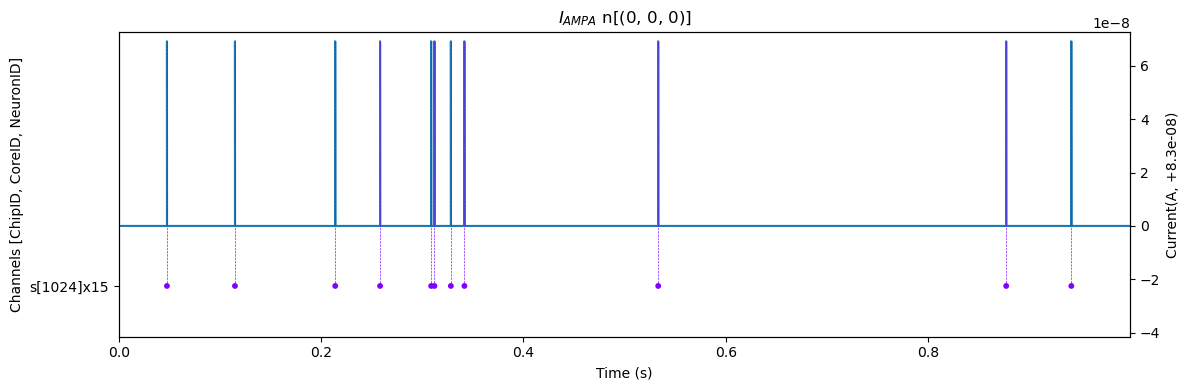

In [25]:
Figure.plot_Isyn_trace(
    input_ts=ts_poisson,
    output_ts=ts_out,
    record_dict=record_dict["1_DynapSim"],
    post=(0, 0, 0),
    syn_name="AMPA",
    router=simconfig.router,
    dt=1e-6,
)


(non-periodic TSContinuous object `$I_{AHP}$ n[(0, 0, 0)]` from t=0.0 to 1.0. Samples: 1000000. Channels: 1,
 non-periodic `TSEvent` object `` from t=0.0 to 1.0. Channels: 1. Events: 22,
 ['n[(0, 0, 0)]x1.0'])

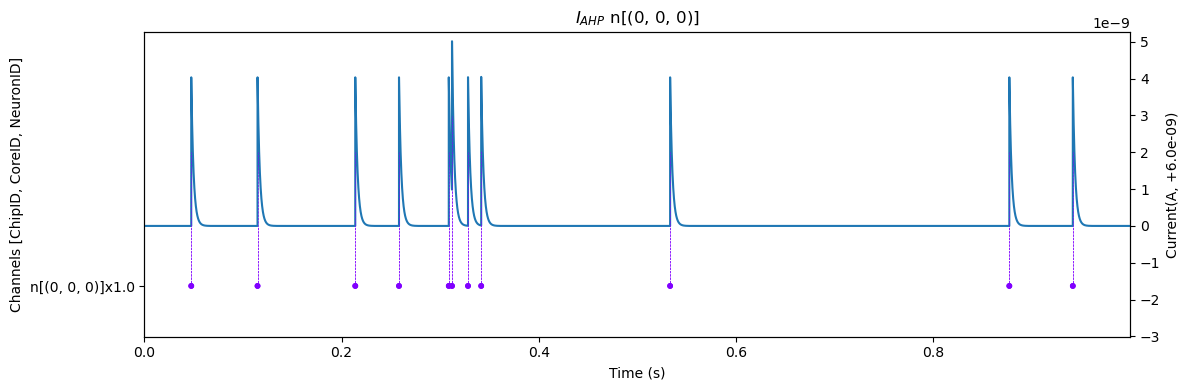

In [26]:
Figure.plot_Isyn_trace(
    input_ts=ts_poisson,
    output_ts=ts_out,
    record_dict=record_dict["1_DynapSim"],
    post=(0, 0, 0),
    syn_name="AHP",
    router=simconfig.router,
    dt=1e-6,
)


In [27]:
simconfig.w_in

DeviceArray([[[6.073194e-07, 0.000000e+00, 0.000000e+00, 0.000000e+00]]],            dtype=float32)

In [28]:
simconfig.w_rec

DeviceArray([[[0., 0., 0., 0.]]], dtype=float32)

In [29]:
simconfig.router.idx_map

{0: (0, 0, 0)}

In [30]:
simconfig.time

DynapSimTime(t_pulse_ahp=array([3.273717e-05]), t_pulse=array([1.35275773e-05]), t_ref=array([0.0107829]), tau_ahp=array([2.48180593]), tau_ampa=array([0.00622751]), tau_gaba=array([1.97456191e-06]), tau_nmda=array([0.02612203]), tau_shunt=array([0.01306161]), tau_mem=array([0.01200967]))

In [31]:
simconfig.gain

DynapSimGain(r_gain_ahp=array([13047.51089153]), r_gain_ampa=array([53.45250766]), r_gain_gaba=array([5.64609701e-07]), r_gain_nmda=array([219.72870351]), r_gain_shunt=array([462.434723]), r_gain_mem=array([1377.48693116]))

In [32]:
simconfig.currents

DynapSimCurrents(Idc=array([2.00646129e-13]), If_nmda=array([5.18291647e-13]), Igain_ahp=array([7.45711315e-09]), Igain_ampa=array([7.45711315e-09]), Igain_gaba=array([2.53494465e-13]), Igain_nmda=array([7.45711315e-09]), Igain_shunt=array([3.07588844e-08]), Igain_mem=array([1.22019259e-08]), Ipulse_ahp=array([1.06912112e-08]), Ipulse=array([2.58730733e-08]), Iref=array([9.73763917e-11]), Ispkthr=array([1.30305448e-08]), Itau_ahp=array([5.71535308e-13]), Itau_ampa=array([1.39509136e-10]), Itau_gaba=array([4.48972918e-07]), Itau_nmda=array([3.39378198e-11]), Itau_shunt=array([6.65150839e-11]), Itau_mem=array([8.85810644e-12]), Iw_ahp=array([1.06912112e-08]))